In [1]:
import time

import matplotlib.pyplot as plt
import nltk
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import wikipediaapi

In [2]:
wiki = wikipediaapi.Wikipedia(user_agent="waynestalk/1.0", language="en")
page = wiki.page("Oolong")
corpus = page.text

nltk.download("punkt")
sentences = nltk.sent_tokenize(corpus)
tokenized_corpus = [[word.lower() for word in nltk.word_tokenize(sentence) if word.isalpha()] for sentence in sentences]
tokenized_corpus[:5]

[nltk_data] Downloading package punkt to /Users/wayne/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


[['oolong',
  'uk',
  'us',
  'simplified',
  'chinese',
  '乌龙茶',
  'traditional',
  'chinese',
  '烏龍茶',
  'pinyin',
  'wūlóngchá',
  'tê',
  'black',
  'dragon',
  'tea',
  'is',
  'a',
  'traditional',
  'chinese',
  'tea',
  'camellia',
  'sinensis',
  'produced',
  'through',
  'a',
  'process',
  'that',
  'includes',
  'withering',
  'the',
  'leaves',
  'under',
  'strong',
  'sun',
  'and',
  'allowing',
  'some',
  'oxidation',
  'to',
  'occur',
  'before',
  'curling',
  'and',
  'twisting'],
 ['most',
  'oolong',
  'teas',
  'especially',
  'those',
  'of',
  'fine',
  'quality',
  'involve',
  'unique',
  'tea',
  'plant',
  'cultivars',
  'that',
  'are',
  'exclusively',
  'used',
  'for',
  'particular',
  'varieties'],
 ['the',
  'degree',
  'of',
  'oxidation',
  'which',
  'is',
  'controlled',
  'by',
  'the',
  'length',
  'of',
  'time',
  'between',
  'picking',
  'and',
  'final',
  'drying',
  'can',
  'range',
  'from',
  'to',
  'depending',
  'on',
  'the',


In [3]:
vocab = set([word for sentence in tokenized_corpus for word in sentence])
word_to_index = {word: i for i, word in enumerate(vocab)}
index_to_word = {i: word for i, word in enumerate(vocab)}
len(vocab)

580

In [4]:
word_frequency = np.zeros(len(vocab))
for sentence in tokenized_corpus:
    for word in sentence:
        word_frequency[word_to_index[word]] += 1
word_frequency = word_frequency / word_frequency.sum()

In [5]:
subsampling_threshold = 1e-5

subsampled_tokenized_corpus = []
for sentence in tokenized_corpus:
    new_sentence = []
    for word in sentence:
        index = word_to_index[word]
        frequency = word_frequency[index]
        if frequency > subsampling_threshold:
            drop_probability = 1 - np.sqrt(subsampling_threshold / frequency)
        else:
            drop_probability = 0

        if np.random.rand() > drop_probability:
            new_sentence.append(word)

    if len(new_sentence) > 0:
        subsampled_tokenized_corpus.append(new_sentence)

print(subsampled_tokenized_corpus[:5])

[['under'], ['fine', 'involve', 'for'], ['controlled', 'drying', 'range'], ['gongfu'], ['can']]


In [6]:
window_size = 2
training_pairs = []

for sentence in subsampled_tokenized_corpus:
    for i, target_word in enumerate(sentence):
        context_indices = (list(range(max(i - window_size, 0), i)) +
                           list(range(i + 1, min(i + window_size + 1, len(sentence)))))
        for context_index in context_indices:
            training_pairs.append((target_word, sentence[context_index]))
training_pairs[:5]

[('fine', 'involve'),
 ('fine', 'for'),
 ('involve', 'fine'),
 ('involve', 'for'),
 ('for', 'fine')]

In [7]:
word_frequency = np.zeros(len(vocab))
for sentence in subsampled_tokenized_corpus:
    for word in sentence:
        word_frequency[word_to_index[word]] += 1
unigram_distribution = word_frequency / word_frequency.sum()

unigram_distribution = unigram_distribution ** (3 / 4)
unigram_distribution = unigram_distribution / unigram_distribution.sum()
print(f"Unigram distribution: {unigram_distribution[:5]}")

def get_negative_samples(num_samples, context_index):
    negative_samples = []
    while len(negative_samples) < num_samples:
        sample_index = np.random.choice(len(vocab), p=unigram_distribution)
        if sample_index != context_index:
            negative_samples.append(sample_index)
    return negative_samples

Unigram distribution: [0.         0.         0.         0.         0.00967459]


In [8]:
class SkipGramWithNegativeSamplingAndSubsamplingOfFrequentWords(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(SkipGramWithNegativeSamplingAndSubsamplingOfFrequentWords, self).__init__()
        self.input_embedding = nn.Embedding(vocab_size, embedding_dim)
        self.output_embedding = nn.Embedding(vocab_size, embedding_dim)
        nn.init.uniform_(self.input_embedding.weight, a=-0.5, b=0.5)
        nn.init.uniform_(self.output_embedding.weight, a=-0.5, b=0.5)

    def forward(self, target_word, context_word, negative_samples):
        target_embedding = self.input_embedding(target_word)
        context_embedding = self.output_embedding(context_word)
        negative_samples_embeddings = self.output_embedding(negative_samples)

        pos_score = (target_embedding * context_embedding).sum(dim=1)
        pos_loss = -torch.sigmoid(pos_score).log()

        neg_score = torch.bmm(negative_samples_embeddings, target_embedding.unsqueeze(2)).squeeze(2)
        neg_loss = -torch.sigmoid(-neg_score).log()
        neg_loss = neg_loss.sum(dim=1)

        return (pos_loss + neg_loss).mean()

In [9]:
model = SkipGramWithNegativeSamplingAndSubsamplingOfFrequentWords(len(vocab), 1000)

num_negative_samples = 5
optimizer = optim.SGD(model.parameters(), lr=0.01)
epochs = 500

start_time = time.time()

for epoch in range(epochs):
    total_loss = 0
    for target, context in training_pairs:
        target_tensor = torch.tensor([word_to_index[target]], dtype=torch.long)
        context_index = word_to_index[context]
        context_tensor = torch.tensor([context_index], dtype=torch.long)
        negative_samples_tensor = torch.tensor(
            [get_negative_samples(num_negative_samples, context_index)], dtype=torch.long
        )
        loss = model(target_tensor, context_tensor, negative_samples_tensor)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    if epoch == 0 or (epoch + 1) % 100 == 0:
        print(f"Epoch: {epoch}, Loss: {total_loss}")

end_time = time.time()
print(f"Training time: {end_time - start_time} seconds")

Epoch: 0, Loss: 789.0757669210434
Epoch: 99, Loss: 40.28482700511813
Epoch: 199, Loss: 25.123359594494104
Epoch: 299, Loss: 22.401581972837448
Epoch: 399, Loss: 23.950490407645702
Epoch: 499, Loss: 20.346398916095495
Training time: 25.867375135421753 seconds


In [10]:
word = "oolong"
word_index_tensor = torch.tensor(word_to_index[word], dtype=torch.long)
embedding_vector = model.input_embedding(word_index_tensor).detach().numpy()
print(f"Embedding {embedding_vector.shape} for '{word}': {embedding_vector}")

Embedding (1000,) for 'oolong': [ 4.05621350e-01  1.81483209e-01 -4.06809628e-01  2.30939686e-01
  1.08531117e-01  1.63119197e-01 -3.92784238e-01  9.52102542e-02
 -3.31382155e-02  3.34345341e-01 -1.09118462e-01 -8.48415494e-02
  1.05704308e-01  1.45459592e-01  4.04628932e-01 -1.15397632e-01
  6.96330070e-02  1.51185393e-01 -1.90357327e-01  4.93192613e-01
 -4.98066545e-02 -5.10013103e-02 -3.02993715e-01 -1.42267108e-01
  5.00079393e-02 -3.12797666e-01 -4.34235871e-01 -2.57645845e-01
 -4.43014443e-01 -2.90615797e-01  2.27307320e-01 -3.02868962e-01
 -4.25365150e-01 -1.94954991e-01 -1.22969687e-01 -1.59589827e-01
  4.91231680e-01 -2.49674320e-02 -3.09211373e-01  4.68738854e-01
 -9.56750512e-02  3.92711163e-02  9.92140770e-02  7.46877193e-02
  2.15017200e-02 -4.84076321e-01  3.46996665e-01  3.02290201e-01
  1.87458634e-01  9.74823236e-02 -5.81416488e-02  3.10133755e-01
  3.28133762e-01 -4.81484711e-01  3.47948670e-01  4.03430223e-01
 -4.41761017e-02  4.98676598e-01 -4.26282763e-01  2.088254

In [11]:
sentence1 = "tea is popular in taiwan".split()
sentence2 = "oolong is famous in taiwan".split()
sentence1_embeddings = [model.input_embedding(torch.tensor(word_to_index[word], dtype=torch.long)).detach() for word in sentence1]
sentence2_embeddings = [model.input_embedding(torch.tensor(word_to_index[word], dtype=torch.long)).detach() for word in sentence2]
vector1 = torch.stack(sentence1_embeddings).mean(dim=0)
vector2 = torch.stack(sentence2_embeddings).mean(dim=0)
cosine_sim = nn.CosineSimilarity(dim=0)
similarity = cosine_sim(vector1, vector2).item()
print(f"Sentence 1: {sentence1}")
print(f"Sentence 2: {sentence2}")
print(f"Similarity between sentences: {similarity}")

Sentence 1: ['tea', 'is', 'popular', 'in', 'taiwan']
Sentence 2: ['oolong', 'is', 'famous', 'in', 'taiwan']
Similarity between sentences: 0.6427488327026367


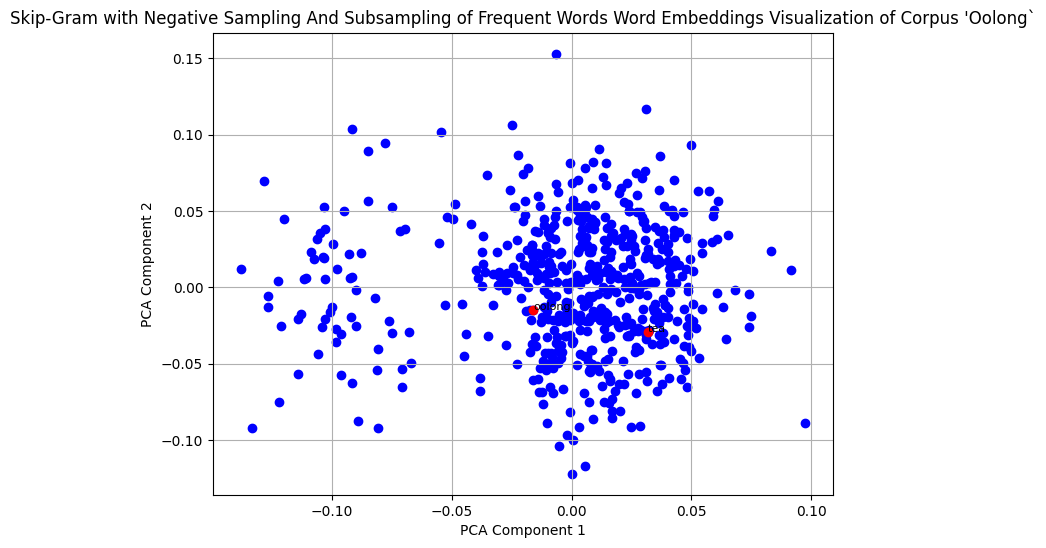

In [12]:
word_embeddings_tensor = model.input_embedding.weight.detach()
U, S, V = torch.pca_lowrank(word_embeddings_tensor, q=2)
reduced_embeddings = U.numpy()

plt.figure(figsize=(8, 6))

for word, index in word_to_index.items():
    x, y = reduced_embeddings[index]
    plt.scatter(x, y, marker='o', color='blue')

tea_index = word_to_index['tea']
x, y = reduced_embeddings[tea_index]
plt.scatter(x, y, marker='o', color='red')
plt.text(x, y, 'tea', fontsize=8)

oolong_index = word_to_index['oolong']
x, y = reduced_embeddings[oolong_index]
plt.scatter(x, y, marker='o', color='red')
plt.text(x, y, 'oolong', fontsize=8)

plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("Skip-Gram with Negative Sampling And Subsampling of Frequent Words Word Embeddings Visualization of Corpus 'Oolong`")
plt.grid(True)
plt.show()